 In this notebook I train a Gaussian Naive Bayes model to predict which class [quarry blast, earthquake, or MIS] an event belongs to based on 12 features computed by Keith and Relu.

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load in the data

In [2]:
# '\s+' tells pandas to use any spaces as the delimiter instead of ,
original_data = pd.read_csv("../data/delivery.2024.04.16.dat", delimiter='\s+')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3341343/3529069451.py:2: SyntaxWarning: invalid escape sequence '\s'
  original_data = pd.read_csv("../data/delivery.2024.04.16.dat", delimiter='\s+')


In [3]:
# Look at the ranges of the values
original_data.describe()

,Elat,Elon,Dep
count,9810.000000,9810.000000,9810.000000
mean,39.800329,-111.790588,5.162487
std,1.255388,0.987518,6.423945
min,36.773000,-114.093000,-3.500000
25%,39.292000,-112.216000,-1.500000
50%,40.460000,-112.049000,6.400000
75%,40.747000,-111.356000,9.400000
max,42.499000,-108.556000,55.800000


In [4]:
original_data.head()

,Date,Time,Elat,Elon,Dep,Tag,F01,F02,F03,F04,F05,F06,F07,F08,F09,F10,F11,F12,F13
0,2012-10-01,16:51:31.20,39.141,-111.655,19.5,eq,0.22,X,0.73,X,-105.1,X,14.36,X,X,X,X,X,X
1,2012-10-01,17:02:17.22,40.500,-112.155,-2.0,ex,0.10,X,X,X,X,X,X,X,X,X,X,X,X
2,2012-10-01,22:38:43.13,40.511,-112.175,-2.0,ex,-0.05,0.27,0.20,-51.4,-84.5,13.40,12.71,X,X,0.37,X,X,0.33
3,2012-10-02,00:21:13.94,39.709,-113.274,-2.0,ex,X,0.14,1.10,-69.4,-110.1,13.02,11.08,X,X,X,X,X,X
4,2012-10-02,18:49:25.22,40.514,-112.161,-2.0,ex,0.00,0.27,0.37,-101.8,-114.7,14.35,12.31,0.14,0.19,0.26,0.40,-0.09,0.21


# Get features and labels

In [5]:
feature_col_names = ['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13']

In [6]:
# Remove gis examples
filtered_data = original_data.drop(np.where(original_data['Tag'] == 'gis')[0])
filtered_data["Tag"].value_counts()

Tag
eq     5837
mis    2043
ex     1540
Name: count, dtype: int64

In [7]:
# Remove rows with missing features
filtered_data = filtered_data[np.all(filtered_data[feature_col_names] != "X", axis=1)]
filtered_data["Tag"].value_counts()

Tag
eq     703
ex     149
mis    112
Name: count, dtype: int64

In [8]:
filtered_data.dtypes

Date     object
Time     object
Elat    float64
Elon    float64
Dep     float64
Tag      object
F01      object
F02      object
F03      object
F04      object
F05      object
F06      object
F07      object
F08      object
F09      object
F10      object
F11      object
F12      object
F13      object
dtype: object

In [9]:
X_df = filtered_data[feature_col_names].astype(float)

In [10]:
# LabelEncoder will transform the class names to numeric values
le = LabelEncoder()
le.fit(filtered_data['Tag'])
print("Original Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
le.classes_ = np.array(['ex', 'eq', 'mis'])
print("Updated Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
y = le.transform(filtered_data['Tag'])
y_cnts = np.unique(y, return_counts=True)[1]
print(y_cnts)

Original Classes ['eq' 'ex' 'mis']
Mapping [0 1 2]
Updated Classes ['ex' 'eq' 'mis']
Mapping [0 1 2]
[149 703 112]


# Do a stratified 80/20 train/test split (try to preserve the class balance)

In [11]:
train_inds, test_inds = train_test_split(np.arange(X_df.shape[0]), 
                                         test_size=0.2, 
                                         shuffle=True, 
                                         random_state=42,
                                         stratify=y)

In [12]:
X_df = X_df.to_numpy()
X_train = X_df[train_inds]
X_test = X_df[test_inds]
y_train = y[train_inds]
y_test = y[test_inds]

In [13]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (771, 13) (771,)
Testing: (193, 13) (193,)
Actual class percentage: [0.15456432 0.72925311 0.11618257]
Training class percentage: [0.15434501 0.72892348 0.11673152]
Testing class percentage: [0.15544041 0.73056995 0.11398964]


# Remove outliers in the training and testing sets 
remove rows with any features > the 99 percentile or < the 1 percentile of that feature in the training set

If I use 95 & 5:
Training: (356, 13) (356,)
Testing: (91, 13) (91,)
Actual class percentage: [0.15456432 0.72925311 0.11618257]
Training class percentage: [0.04494382 0.88764045 0.06741573]
Testing class percentage: [0.01098901 0.94505495 0.04395604]

99 & 1:
Training: (643, 13) (643,)
Testing: (168, 13) (168,)
Actual class percentage: [0.15456432 0.72925311 0.11618257]
Training class percentage: [0.13685848 0.75583204 0.10730949]
Testing class percentage: [0.08928571 0.76785714 0.14285714]

In [14]:
low_percentile, high_percentile = np.percentile(X_train, [1, 99], axis=0)
train_inds_to_drop = np.unique((np.concatenate([np.where(X_train >  high_percentile)[0],
                                          np.where(X_train < low_percentile)[0]])))
test_inds_to_drop = np.unique((np.concatenate([np.where(X_test >  high_percentile)[0],
                                          np.where(X_test < low_percentile)[0]])))
print(train_inds_to_drop.shape, test_inds_to_drop.shape)

(121,) (41,)


In [15]:
filtered_train_inds = np.delete(train_inds, train_inds_to_drop)
filtered_test_inds = np.delete(test_inds, test_inds_to_drop)
X_train = X_df[filtered_train_inds]
X_test = X_df[filtered_test_inds]
y_train = y[filtered_train_inds]
y_test = y[filtered_test_inds]

In [16]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (650, 13) (650,)
Testing: (152, 13) (152,)
Actual class percentage: [0.15456432 0.72925311 0.11618257]
Training class percentage: [0.12615385 0.75846154 0.11538462]
Testing class percentage: [0.09210526 0.80263158 0.10526316]


In [17]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([ 14, 122,  16]))

# Train a Gaussian Naive Bayes model

In [18]:
nb = GaussianNB()

In [19]:
nb.fit(X_train, y_train)

GaussianNB()

In [20]:
y_pred_train = nb.predict(X_train)

In [21]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)

[[ 79   0   3]
 [  5 488   0]
 [  7   0  68]]


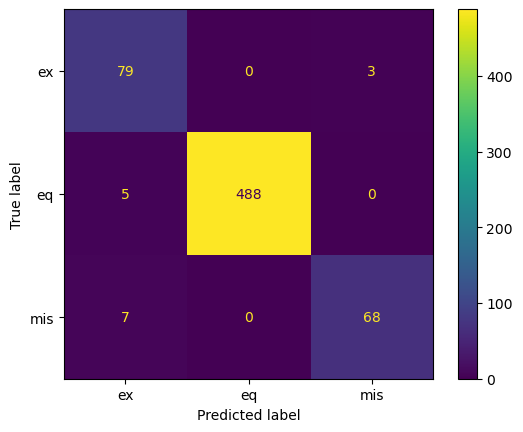

In [22]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=le.classes_)
display.plot()

In [23]:
f1_score(y_train, y_pred_train, average='macro')

0.946568269014568

# Evaluate the GNB model on the testing set
Use F1 score - which is the harmonic mean of precision and recall. `averaging="macro"` means that the F1 score for each of the classes is simply averaged. I chose this because I care about all the classes equally and don't want to give more weight to eq.

In [24]:
y_pred_test = nb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[ 12   0   2]
 [  1 121   0]
 [  2   0  14]]


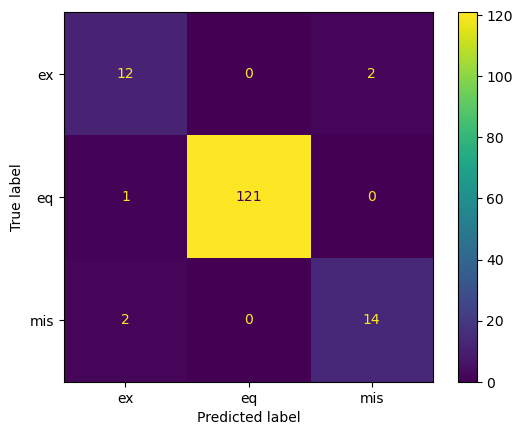

In [25]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=le.classes_)
display.plot()

In [26]:
f1_score(y_test, y_pred_test, average='macro')

0.8994903268530344